[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-repo/CIFAR10_FFNN_Lab.ipynb)

> Click to launch in Google Colab. In Colab: **Runtime → Change runtime type → GPU**.

# Image Classification (CIFAR‑10) with a Convolutional Neural Network: Training Dynamics & Evaluation


**Weighting (Total 5%)**
- **In‑Lab (3 hours):**
  - A1: Pipeline working on subset, with logs/curves (1.0%)
  - A2: Architecture is correct (no flatten at input), shapes verified basic accuracy target met (0.8%)
  - A3: Clean code & brief in lab notes (0.2%)
  - A4: Save and load model checkpoints (NOT graded, but recommended)

- **Take‑Home (1 week):**
  - B1: Full data training + ≥2 augmentations, settings documented (1.0%)
  - B2: Results quality (within reasonable band for your setup) + clear plots/tables (1.0%)
  - B3: Fair comparison to A2 with thoughtful discussion (0.7%)
  - B4: Reproducibility (seeds, README, runtime notes) (0.3%)

**Learning goals**

By the end of this assignment, you should be able to:
- Explain why CNNs do not flatten the image at the input and how spatial structure is preserved layer to layer.
- Implement a compact CNN (Conv→ReLU→Pool stacks; optional BatchNorm/Dropout) and train it on CIFAR 10.
- Use common augmentations (random crop/flip/colour jitter/cutout) and discuss their impact on generalization.
- Run a fair comparison against a fully connected baseline (from A2) using matched training setups and report metrics clearly.

**Instructions**: Run cells top‑to‑bottom. For the take‑home, edit the designated section and keep your changes minimal but clear.

In [1]:
# ✅ Device setup (CPU/GPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

from collections.abc import Mapping, Sequence
def to_device(obj, device=device):
    if hasattr(obj, 'to'):
        try:
            return obj.to(device)
        except Exception:
            return obj
    if isinstance(obj, Mapping):
        return obj.__class__({k: to_device(v, device) for k, v in obj.items()})
    if isinstance(obj, Sequence) and not isinstance(obj, (str, bytes)):
        return obj.__class__([to_device(v, device) for v in obj])
    return obj

Using device: cpu


Importing some required libraries. You can add more if needed.

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

## Part A: Data Loading & Normalization

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

SEED = 328  # pick any int and report it in the PDF

#random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# Load the CIFAR-10 dataset
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# DataLoader definitions
root = './data'
full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_ds    = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)
val_size = 5000
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 170M/170M [00:06<00:00, 25.4MB/s] 


(45000, 5000, 10000)

## Part A: Model, Training Loop, and Curves (In‑Lab)

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = CIFAR10_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# --- metric logs (lists) ---
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

# ---- Training loop ----
num_epochs = 15
best_val = 0.0

for epoch in range(num_epochs):
    # Train
    model.train()
    run_loss, run_correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        run_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = run_loss / total
    train_acc  = run_correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_loss_cum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            val_loss_cum += loss.item() * labels.size(0)
            val_correct  += (logits.argmax(1) == labels).sum().item()
            val_total    += labels.size(0)

    val_loss = val_loss_cum / val_total
    val_acc  = val_correct  / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch}, 'best_cifar10.ckpt')

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

# ---- Plotting ----
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses,   label='Validation Loss', marker='s')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accs,   label='Validation Accuracy', marker='s')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Epoch 01/15 | train loss 1.5025 acc 0.466 | val loss 1.2870 acc 0.541
Epoch 02/15 | train loss 1.1404 acc 0.603 | val loss 1.0807 acc 0.630
Epoch 03/15 | train loss 0.9967 acc 0.656 | val loss 0.9866 acc 0.662
Epoch 04/15 | train loss 0.9074 acc 0.689 | val loss 0.9485 acc 0.673
Epoch 05/15 | train loss 0.8527 acc 0.708 | val loss 0.9088 acc 0.693
Epoch 06/15 | train loss 0.8000 acc 0.725 | val loss 0.8772 acc 0.700
Epoch 07/15 | train loss 0.7510 acc 0.741 | val loss 0.8624 acc 0.705
Epoch 08/15 | train loss 0.7157 acc 0.758 | val loss 0.8544 acc 0.706
Epoch 09/15 | train loss 0.6842 acc 0.766 | val loss 0.8344 acc 0.716
Epoch 10/15 | train loss 0.6449 acc 0.780 | val loss 0.8439 acc 0.714


## Part A: Save and load model checkpoints (NOT graded, but recommended)

In [ ]:
import torch

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "cnn_checkpoint.pth")

## PART B: Take Home

#### **Goal:** Train on full CIFAR 10 with augmentations, tune modestly, and compare to your A2 fully connected NN.

1. **Required augmentations (choose ≥2):**
- RandomCrop(32, padding=4)
- RandomHorizontalFlip()
- ColorJitter (mild)
- RandomErasing / Cutout (small holes)

Describe each choice and its expected effect.


In [ ]:
# ==== AUGMENTED CIFAR-10 + TRAIN/VAL SPLIT + TRAIN LOOP + PLOTS ====
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- CIFAR-10 normalization ----
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

# ---- Transforms (augmented train, clean val/test) ----
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# ---- Datasets & split (keeps val clean) ----
root = './data'
# split indices first so val doesn't inherit train augmentations
base_train = datasets.CIFAR10(root, train=True, download=True, transform=None)
val_size   = 5000
train_size = len(base_train) - val_size
train_subset, val_subset = random_split(base_train, [train_size, val_size])

full_train_tf = datasets.CIFAR10(root, train=True,  download=False, transform=train_tf)
full_val_tf   = datasets.CIFAR10(root, train=True,  download=False, transform=test_tf)
test_ds       = datasets.CIFAR10(root, train=False, download=True,  transform=test_tf)

train_ds = Subset(full_train_tf, train_subset.indices)
val_ds   = Subset(full_val_tf,   val_subset.indices)

# ---- DataLoaders ----
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(len(train_ds), len(val_ds), len(test_ds))  # 45000 5000 10000


45000 5000 10000


2. **Training protocol:**
- Epochs: 30–60 (pick and justify); **Optimizer:** Adam or SGD+Momentum.
- LR schedule: optional StepLR or CosineAnnealing. State settings.
- Regularization: optional weight decay (e.g., 5e 4). Track training time & best epoch.
- Validation: hold out 5k images from training as validation (or use test set only for final report—be explicit and consistent).
- **Save the best performing model.**


Epoch 01/50 | train loss 1.6540 acc 0.406 | val loss 1.2958 acc 0.536 | 
Epoch 02/50 | train loss 1.3732 acc 0.515 | val loss 1.1454 acc 0.597 | 
Epoch 03/50 | train loss 1.2563 acc 0.556 | val loss 1.0744 acc 0.613 | 
Epoch 04/50 | train loss 1.1922 acc 0.583 | val loss 0.9920 acc 0.645 | 
Epoch 05/50 | train loss 1.1454 acc 0.598 | val loss 0.9523 acc 0.665 | 
Epoch 06/50 | train loss 1.1115 acc 0.613 | val loss 0.9452 acc 0.672 | 
Epoch 07/50 | train loss 1.0783 acc 0.624 | val loss 0.9324 acc 0.673 | 
Epoch 08/50 | train loss 1.0539 acc 0.635 | val loss 0.8776 acc 0.699 | 
Epoch 09/50 | train loss 1.0419 acc 0.637 | val loss 0.9153 acc 0.680 | 
Epoch 10/50 | train loss 1.0185 acc 0.647 | val loss 0.8647 acc 0.697 | 
Epoch 11/50 | train loss 1.0031 acc 0.654 | val loss 0.8660 acc 0.700 | 
Epoch 12/50 | train loss 0.9909 acc 0.657 | val loss 0.8381 acc 0.707 | 
Epoch 13/50 | train loss 0.9838 acc 0.660 | val loss 0.8259 acc 0.712 | 
Epoch 14/50 | train loss 0.9635 acc 0.666 | val los

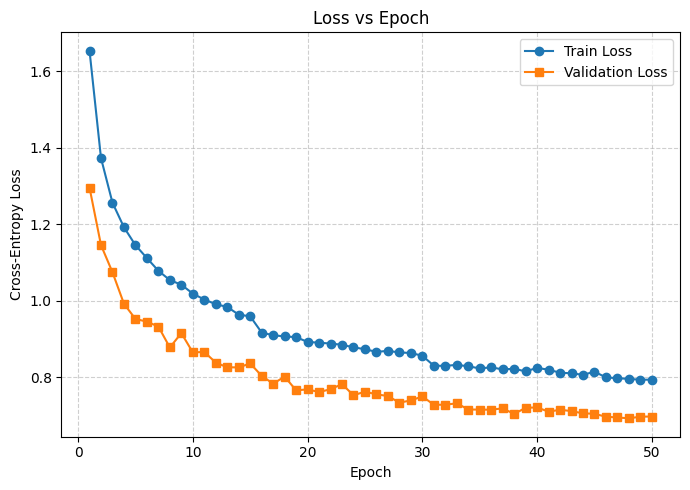

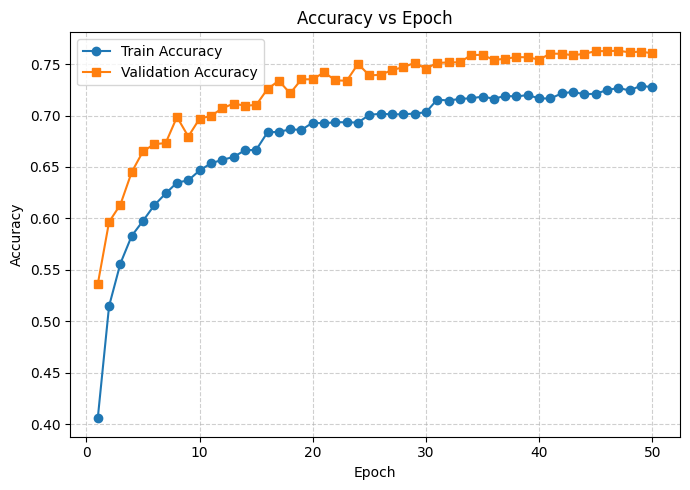

In [ ]:
import time
from torch.optim.lr_scheduler import StepLR

# --- Metric trackers ---
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

# --- Model, optimizer, scheduler ---
model = CIFAR10_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 50
best_val = 0.0
best_epoch = -1
start_time = time.time()

# ============================================================
#                        TRAIN + VALIDATION
# ============================================================
for epoch in range(num_epochs):

    # ---- TRAIN ----
    model.train()
    run_loss, run_correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        run_loss   += loss.item() * labels.size(0)
        run_correct += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    train_loss = run_loss / total
    train_acc  = run_correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ---- VALIDATION ----
    model.eval()
    val_loss_cum, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)

            val_loss_cum += loss.item() * labels.size(0)
            val_correct  += (logits.argmax(1) == labels).sum().item()
            val_total    += labels.size(0)

    val_loss = val_loss_cum / val_total
    val_acc  = val_correct  / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # ---- Save best model ----
    if val_acc > best_val:
        best_val = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_cifar10_model.pt")

    scheduler.step()

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

# ============================================================
#                       TEST EVALUATION
# ============================================================

# ---- Load best model (important!) ----
best_model = CIFAR10_CNN().to(device)
best_model.load_state_dict(torch.load("best_cifar10_model.pt"))
best_model.eval()

test_loss_cum, test_correct, test_total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = best_model(images)
        loss = criterion(logits, labels)

        test_loss_cum += loss.item() * labels.size(0)
        test_correct  += (logits.argmax(1) == labels).sum().item()
        test_total    += labels.size(0)

test_loss = test_loss_cum / test_total
test_acc  = test_correct  / test_total

end_time = time.time()

print("\n✅ Training complete.")
print(f"✅ Best validation accuracy: {best_val:.3f} (epoch {best_epoch})")
print(f"🧪 Test accuracy: {test_acc:.3f}")
print(f"⏱️ Total training time: {end_time - start_time:.2f} seconds")

# ============================================================
#                       PLOTS
# ============================================================

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Validation Loss')
plt.title('Loss vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.4)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs,   label='Validation Accuracy')
plt.title('Accuracy vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True, alpha=0.4)
plt.show()


3. **Fair comparison to A2 (fully connected):**
- Re run (or reuse) your A2 MLP with the same data split and similar epoch budget.
- Report accuracy, loss, and at least one calibration/uncertainty proxy (e.g., confidence histograms or softmax max prob distribution).
- Briefly discuss: Why does the CNN outperform (or not)? Tie to spatial bias, parameter efficiency, and augmentation.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h_dim in hidden_dims:
            layers += [nn.Linear(last_dim, h_dim), nn.ReLU()]
            last_dim = h_dim
        layers += [nn.Linear(last_dim, output_dim)]  # logits (no activation)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, C, H, W) -> flatten
        x = x.view(x.size(0), -1)
        return self.net(x)

# ---- setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 3 * 32 * 32  # CIFAR-10 flattened
hidden_layers = [1024, 512] # Changed from [512, 256]
output_dim = 10

model_A2 = FFNN(input_dim=input_dim, hidden_dims=hidden_layers, output_dim=output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_A2.parameters(), lr=1e-4) # lr changed from 1e-3

# You should define train_ds and val_ds elsewhere
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_epochs = 15 # Changed from 10

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    # ---- TRAIN ----
    model_A2.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model_A2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += bs

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = running_correct / running_total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # ---- VALIDATE ----
    model_A2.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model_A2(inputs)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            val_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += bs

    epoch_valid_loss = val_loss / len(val_loader.dataset)
    epoch_valid_acc  = val_correct / val_total
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_acc)

    print(f"Epoch {epoch}/{num_epochs}: "
          f"Train Loss {epoch_train_loss:.4f} | Train Acc {epoch_train_acc:.4f} || "
          f"Val Loss {epoch_valid_loss:.4f} | Val Acc {epoch_valid_acc:.4f}")


Epoch 1/15: Train Loss 1.8611 | Train Acc 0.3304 || Val Loss 1.6858 | Val Acc 0.4012
Epoch 2/15: Train Loss 1.6964 | Train Acc 0.3954 || Val Loss 1.6268 | Val Acc 0.4268
Epoch 3/15: Train Loss 1.6321 | Train Acc 0.4201 || Val Loss 1.5373 | Val Acc 0.4488
Epoch 4/15: Train Loss 1.5885 | Train Acc 0.4365 || Val Loss 1.5092 | Val Acc 0.4632
Epoch 5/15: Train Loss 1.5546 | Train Acc 0.4484 || Val Loss 1.5034 | Val Acc 0.4694
Epoch 6/15: Train Loss 1.5308 | Train Acc 0.4526 || Val Loss 1.4684 | Val Acc 0.4740
Epoch 7/15: Train Loss 1.5084 | Train Acc 0.4643 || Val Loss 1.4469 | Val Acc 0.4896
Epoch 8/15: Train Loss 1.4865 | Train Acc 0.4682 || Val Loss 1.4499 | Val Acc 0.4810
Epoch 9/15: Train Loss 1.4715 | Train Acc 0.4782 || Val Loss 1.4148 | Val Acc 0.4970
Epoch 10/15: Train Loss 1.4522 | Train Acc 0.4845 || Val Loss 1.4185 | Val Acc 0.4946
Epoch 11/15: Train Loss 1.4443 | Train Acc 0.4850 || Val Loss 1.3829 | Val Acc 0.5158
Epoch 12/15: Train Loss 1.4253 | Train Acc 0.4930 || Val Loss 1

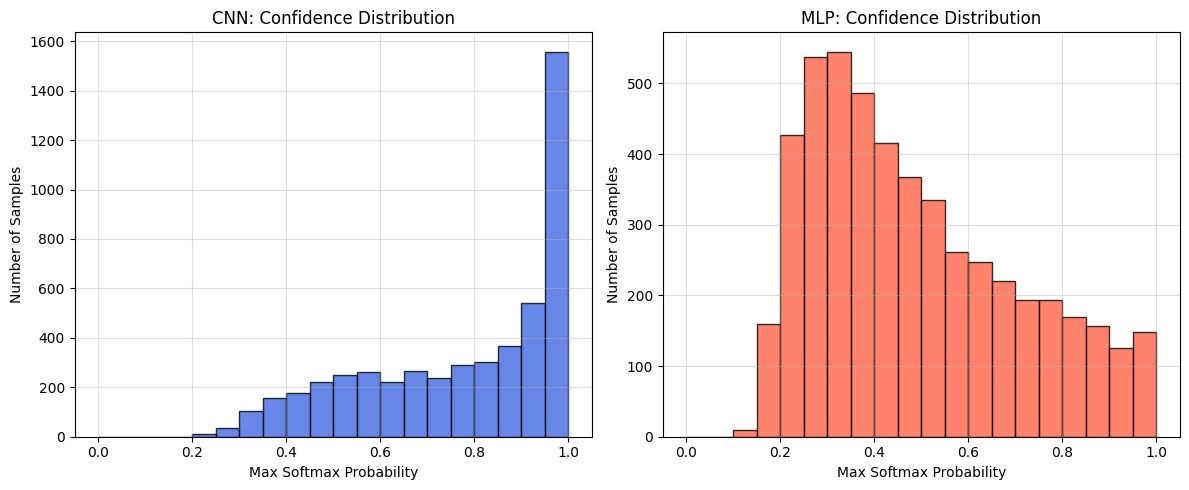

'\n\n# --- Optional: Print calibration stats ---\nprint(f"CNN avg confidence (correct):   {cnn_conf[cnn_correct==1].mean():.3f}")\nprint(f"CNN avg confidence (incorrect): {cnn_conf[cnn_correct==0].mean():.3f}")\nprint(f"MLP avg confidence (correct):   {mlp_conf[mlp_correct==1].mean():.3f}")\nprint(f"MLP avg confidence (incorrect): {mlp_conf[mlp_correct==0].mean():.3f}")\n'

In [ ]:

def collect_confidences(model, dataloader, device):
    model.eval()
    confidences = []
    correct_flags = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            max_probs, preds = probs.max(dim=1)
            confidences.extend(max_probs.cpu().numpy())
            correct_flags.extend((preds == labels).cpu().numpy())
    return np.array(confidences), np.array(correct_flags)

# --- Collecting for both models ---
cnn_conf, cnn_correct = collect_confidences(model, val_loader, device)
mlp_conf, mlp_correct = collect_confidences(model_A2, val_loader, device)

# --- Plotting side by side ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(cnn_conf, bins=20, range=(0, 1), color='royalblue', edgecolor='black', alpha=0.8)
plt.title("CNN: Confidence Distribution")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Number of Samples")
plt.grid(alpha=0.4)

plt.subplot(1, 2, 2)
plt.hist(mlp_conf, bins=20, range=(0, 1), color='tomato', edgecolor='black', alpha=0.8)
plt.title("MLP: Confidence Distribution")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Number of Samples")
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

'''

# --- Optional: Print calibration stats ---
print(f"CNN avg confidence (correct):   {cnn_conf[cnn_correct==1].mean():.3f}")
print(f"CNN avg confidence (incorrect): {cnn_conf[cnn_correct==0].mean():.3f}")
print(f"MLP avg confidence (correct):   {mlp_conf[mlp_correct==1].mean():.3f}")
print(f"MLP avg confidence (incorrect): {mlp_conf[mlp_correct==0].mean():.3f}")
'''

---
**Deliverables checklist:**
- Part A subset run with curves &amp; quick notes
- Part B full run with ≥2 augmentations
- Comparison table vs A2 (MLP)
- 3-page PDF report with plots &amp; examples
- Repro instructions + seeds

### Deadline for take‑home is **one week** after your lab session.